# House Prices Prediction Notebook

# Part 1 - DEFINE
***

### ---- 1 Define the problem ----

In this notebook, using the Kaggle [dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv), first, I'll establish simple baseline model, and then I'll develop a few predictive models and compare the performance against the baseline 

### Objective: 
- To understand what factors contribut most to house prices.

- To create a model that predicts the price of a house with a given several features. 

- To create or improve predictive accuracy of the model compared to baseline model

The implementation of this model will allow housing agencies (e.g., CMHC), real-estate companies, banks, municipial governments and home buyers to make informed decisions.

### Check versions of the Python and some key packages to ensure most recent version is used

In [678]:
%load_ext watermark
%watermark -a 'Vusal Babashov' -u -d -v -p numpy,mlxtend,matplotlib,sklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Vusal Babashov

Last updated: 2021-02-18

Python implementation: CPython
Python version       : 3.8.2
IPython version      : 7.20.0

numpy     : 1.19.2
mlxtend   : 0.18.0
matplotlib: 3.3.2
sklearn   : 0.23.2



### Import Libraries

In [679]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

#your info here
__author__ = "Vusal Babashov"
__email__ = "vbabashov@gmail.com"

## Part 2 - DISCOVER
***

### ---- 2 Load the data ----

In [680]:
#load the data into a Pandas dataframe
# read dataset
file_path = "/Users/vusalbabashov/Desktop/house-prices/data/"
df_train = pd.read_csv(file_path + "train.csv")
df_test_feature = pd.read_csv(file_path + "test.csv")
df_test_target = pd.read_csv(file_path + "sample_submission.csv")

### ---- 3 Examine the data ----

In [681]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [682]:
df_test_feature.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [683]:
df_test_target.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


### ---- 4 Data Pre-Processing ----

In [684]:
# Check the size of the rows and columns
df_train.shape

(1460, 81)

In [685]:
# Check the size of the rows and columns
df_test_feature.shape

(1459, 80)

In [686]:
# Check the size of the rows and columns
df_test_target.shape

(1459, 2)

In [687]:
#Check for duplicates
df_train.duplicated().sum()

0

In [688]:
#Check for duplicates
df_test_feature.duplicated().sum()

0

In [689]:
#Use .info() to see length and dtypes
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [690]:
# check if there is a missing value in each column and how many missing cells
with pd.option_context('display.max_rows', None):
    display(df_train.isnull().sum())

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

We can see that some columns have signifantly large number of missing values than others. So I decided to drop a column if more than 80% (arbitrary choice!) of the values are missing.

In [691]:
def clean_and_impute_missing_data (df):
    '''drops the columns with 80% or hihgher missingness and imputes the continious columns with mean and categorical columns with most frequent value'''
    imputer_con = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    dropped_df = df.drop(df.columns[df.apply(lambda col: (col.isnull().sum())/df.shape[0] >= 0.8)], axis=1)
    for col in dropped_df.columns:    
        if dropped_df[col].isnull().sum() > 0:   
            if dropped_df[col].dtype.name == 'object':
                 dropped_df[col] = imputer_cat.fit_transform(dropped_df[col].values.reshape(-1,1))
            else:            
                dropped_df[col] = imputer_con.fit_transform(dropped_df[col].values.reshape(-1,1))
    return dropped_df          

In [692]:
def convert_data_types (df):
    ''' converts the types of data columns into the appropriate type'''
    for col in df.columns: 
        if df[col].dtype.name == 'object':
             df[col]=df[col].astype('category')
        else:
             df[col]=df[col].astype('int')
    df['MSSubClass'] = df['MSSubClass'].astype('category')
    df['MoSold'] = df['MoSold'].astype('category')  
    return df            

In [693]:
def get_target_df(df, target):
    '''returns target dataframe'''
    return df[target]

In [704]:
def list_of_categorical_and_continious_variables(df):
    '''determine the categorical and continous variables'''
    categorical_cols = []
    numerical_cols = []
    drop_cols = ['MoSold', 'GarageYrBlt', 'YrSold', 'SalePrice']
    df=df.drop (columns=drop_cols)
    for col in df.columns:
        if df[col].dtype.name == 'category':
            categorical_cols.append(col)
        else: 
            numerical_cols.append(col)   
    return categorical_cols, numerical_cols

In [705]:
def one_hot_encode_feature_df(df, cat_vars, num_vars):
    '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)#,ignore_index=False)

In [707]:
# clean and impute the missing 
cleaned_and_imputed_df = clean_and_impute_missing_data (df_train) 
# Conver the types object to categorical and numeric to integer
type_converted_df = convert_data_types (cleaned_and_imputed_df)
# Iterate and get the list of categorical and numerical columns
categorical_vars, numerical_vars = list_of_categorical_and_continious_variables(type_converted_df)
target_var = 'SalePrice'
#encode categorical data and get final feature dfs
feature_df = one_hot_encode_feature_df(type_converted_df, categorical_vars, numerical_vars)
#get target df
target_df = get_target_df(type_converted_df, target_var)

In [708]:
feature_df.head()

,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,0,0,0,0,0,1,0,0,0,0,...,0,2,548,0,61,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,1,2,460,298,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,1,2,608,0,42,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,1,3,642,0,35,272,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,1,3,836,192,84,0,0,0,0,0


### ---- 4 Explore the data (EDA) ----

In [ ]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

#### Summarize Numerical Variables

In [103]:
# Summarize numerical variables
df_train.describe(include = [np.number])

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### Summarize Categorical Variables

In [104]:
# Summarize categorical variables
df_train.describe(include = ['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


#### Visualize target variable (SalePrice)

<Figure size 1152x432 with 0 Axes>

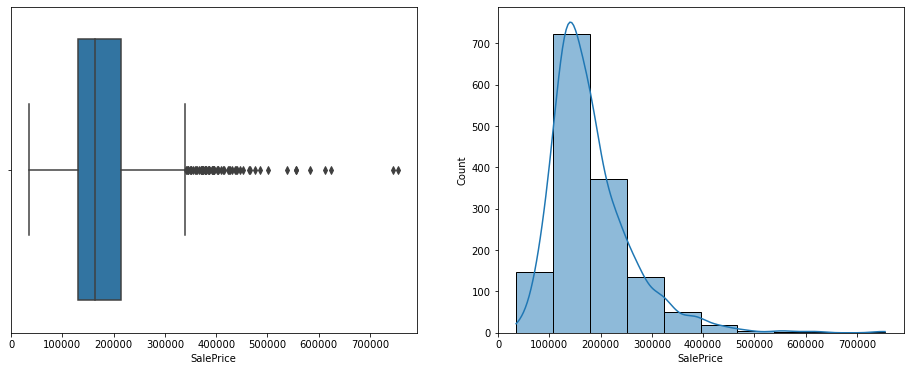

In [144]:
plt.figure(figsize = (16, 6))
f, axes = plt.subplots(1, 2, figsize = (16, 6))
sns.boxplot(x=df_train["SalePrice"],  ax=axes[0])
sns.histplot(df_train["SalePrice"], kde=True, bins = 10,  ax=axes[1])
plt.show()

### ---- 5 Establish a baseline ----

In [ ]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [ ]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data